In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import tensorflow as tf

from packages import utils
np.set_printoptions(precision=2) # sets the precision of floating-point numbers when they are printed using NumPy's array printing functions

tf.get_logger().setLevel('ERROR') 
''' line sets the logging level of TensorFlow's default logger to 'ERROR', which means only messages of level 'ERROR' and above will be displayed. This can be useful to suppress informational or debug messages and only show messages related to errors'''

#tf.logging.set_verbosity(0)
'''line sets the verbosity level of TensorFlow's logging system to 0, which corresponds to logging level FATAL. This means that only messages of level FATAL will be displayed. This is the highest level of logging and is typically used to only show messages for critical errors that cause the program to terminate.'''
#newer versions of TensorFlow, the tf.logging module has been removed. To achieve the same effect as tf.logging.set_verbosity(0)  

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [25]:
df=np.loadtxt('data/data_w3_ex1.csv',delimiter=',')

x=df[:,0]
y=df[:,1]

x=np.expand_dims(x,axis=1) #effectively converting them from 1D arrays to 2D column vectors. 
y=np.expand_dims(y,axis=1) #This is often done to prepare the data for certain operations or algorithms that expect 2D input.


print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (50, 1)
y shape: (50, 1)


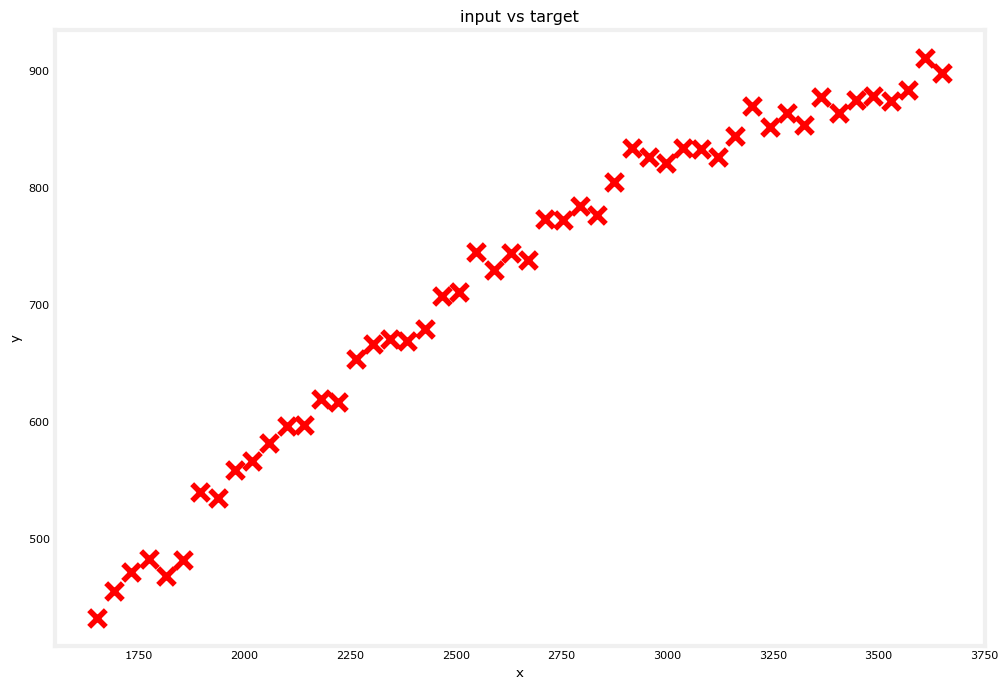

In [26]:
utils.plot_dataset(x=x,y=y,title='input vs target')
#show the data in dataset visually

Split the dataset into training, cross validation, and test sets
training set - used to train the model
cross validation set (also called validation, development, or dev set) - used to evaluate the different model configurations you are choosing from. For example, you can use this to make a decision on what polynomial features to add to your dataset.
test set - used to give a fair estimate of your chosen model's performance against new examples. This should not be used to make decisions while you are still developing the models

Scikit-learn provides a train_test_split function to split your data into the parts mentioned above. In the code cell below, you will split the entire dataset into 60% training, 20% cross validation, and 20% test.

In [27]:
x_train,x_,y_train,y_=train_test_split(x,y,test_size=0.4,random_state=1)

x_cv,x_test,y_cv,y_test=train_test_split(x_,y_,test_size=0.5,random_state=1)

del x_,y_

print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")
print(f"x_cv.shape: {x_cv.shape}")
print(f"y_cv.shape: {y_cv.shape}")


x_train.shape: (30, 1)
y_train.shape: (30, 1)
x_test.shape: (10, 1)
y_test.shape: (10, 1)
x_cv.shape: (10, 1)
y_cv.shape: (10, 1)


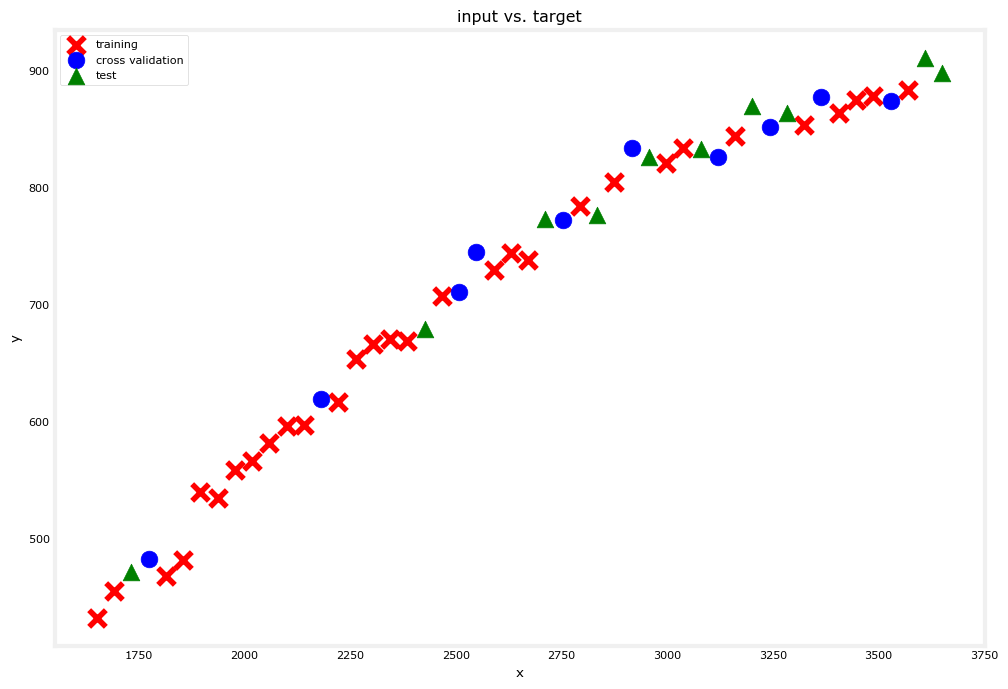

In [28]:
utils.plot_train_cv_test(x_train,y_train,x_cv,y_cv,x_test,y_test,title='data classification')

### Feature scaling
it is usually a good idea to perform feature scaling to help your model converge faster. This is especially true if your input features have widely different ranges of values. Later in this lab, you will be adding polynomial terms so your input features will indeed have different ranges. For example, $x$ runs from around 1600 to 3600, while $x^2$ will run from 2.56 million to 12.96 million. 

You will only use $x$ for this first model but it's good to practice feature scaling now so you can apply it later. For that, you will use the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class from scikit-learn. This computes the z-score of your inputs. As a refresher, the z-score is given by the equation:

$$ z = \frac{x - \mu}{\sigma} $$

where $\mu$ is the mean of the feature values and $\sigma$ is the standard deviation. The code below shows how to prepare the training set using the said class. You can plot the results again to inspect if it still follows the same pattern as before. The new graph should have a reduced range of values for `x`.

compute the mean of the training set: 2504.06
compute the std of the training set: 574.85


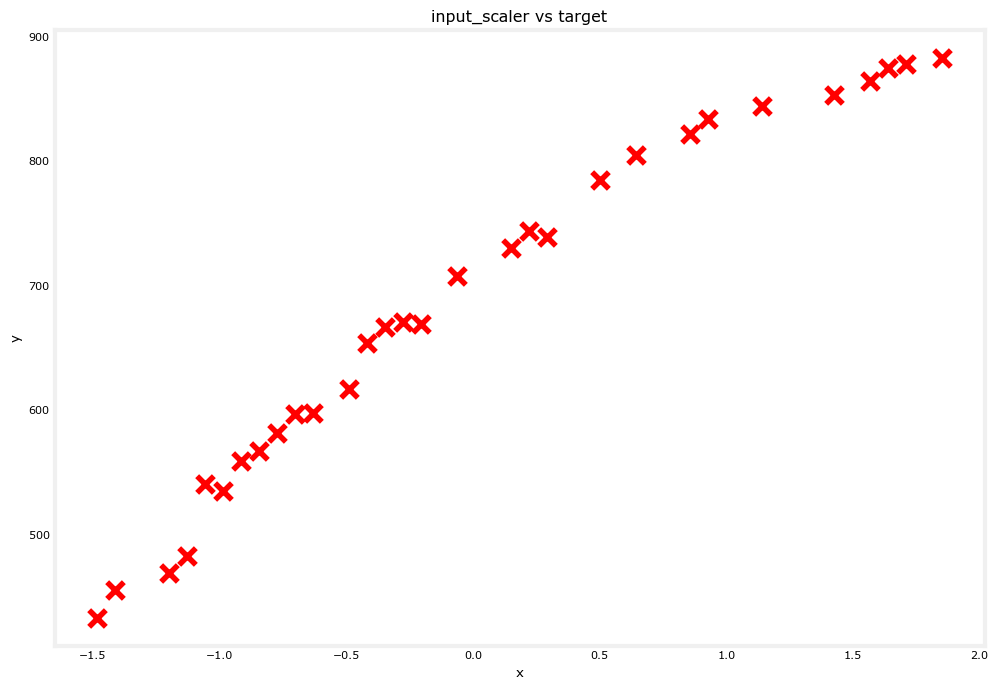

In [29]:
SL=StandardScaler()
x_scaled=SL.fit_transform(x_train)

print(f"compute the mean of the training set: {SL.mean_.squeeze():.2f}")
print(f"compute the std of the training set: {SL.scale_.squeeze():.2f}")

#plot 
utils.plot_dataset(x=x_scaled,y=y_train,title='input_scaler vs target')

### TRAIN MODEL

In [30]:
LR=LinearRegression()

LR.fit(x_scaled,y_train)

LinearRegression()

### Evaluate the Model

To evaluate the performance of your model, you will measure the error for the training and cross validation sets. For the training error, recall the equation for calculating the mean squared error (MSE):

$$J_{train}(\vec{w}, b) = \frac{1}{2m_{train}}\left[\sum_{i=1}^{m_{train}}(f_{\vec{w},b}(\vec{x}_{train}^{(i)}) - y_{train}^{(i)})^2\right]$$

Scikit-learn also has a built-in mean_squared_error() function that you can use.scikit-learn's implementation only divides by `m` and not `2*m`, where `m` is the number of examples. As mentioned in Course 1 of this Specialization (cost function lectures), dividing by `2m` is a convention we will follow but the calculations should still work whether or not you include it. Thus, to match the equation above, you can use the scikit-learn function then divide by 2 as shown below. We also included a for-loop implementation so you can check that it's equal. 

Another thing to take note: Since you trained the model on scaled values (i.e. using the z-score), you should also feed in the scaled training set instead of its raw values.

In [31]:
y_pred=LR.predict(x_scaled)
print(f"training mse:{ mean_squared_error(y_train, y_pred)/2 }")

total_error=0
for i in range(len(y_pred)):
    sq_error=(y_pred[i]-y_train[i])**2
    total_error += sq_error
mse=total_error/(2*len(y_pred))
print(f"for loop mse caluclation error: {mse.squeeze()}")

training mse:406.19374192533127
for loop mse caluclation error: 406.19374192533127


You can then compute the MSE for the cross validation set with basically the same equation:

$$J_{cv}(\vec{w}, b) = \frac{1}{2m_{cv}}\left[\sum_{i=1}^{m_{cv}}(f_{\vec{w},b}(\vec{x}_{cv}^{(i)}) - y_{cv}^{(i)})^2\right]$$

As with the training set, you will also want to scale the cross validation set. An *important* thing to note when using the z-score is you have to use the mean and standard deviation of the **training set** when scaling the cross validation set. This is to ensure that your input features are transformed as expected by the model. One way to gain intuition is with this scenario:

* Say that your training set has an input feature equal to `500` which is scaled down to `0.5` using the z-score.
* After training, your model is able to accurately map this scaled input `x=0.5` to the target output `y=300`. 
* Now let's say that you deployed this model and one of your users fed it a sample equal to `500`. 
* If you get this input sample's z-score using any other values of the mean and standard deviation, then it might not be scaled to `0.5` and your model will most likely make a wrong prediction (i.e. not equal to `y=300`). 

You will scale the cross validation set below by using the same `StandardScaler` you used earlier but only calling its [`transform()`]

In [32]:
x_cv_scaled=SL.transform(x_cv)

print(f"compute the mean of the validation set: {SL.mean_.squeeze():.2f}")
print(f"compute the std of the validation set: {SL.scale_.squeeze():.2f}")

y_pred=LR.predict(x_cv_scaled)

print(f"training mse:{ mean_squared_error(y_cv, y_pred)/2 } ")

compute the mean of the validation set: 2504.06
compute the std of the validation set: 574.85
training mse:551.7789026952216 


# Adding polynomial function 

From the graphs earlier, you may have noticed that the target `y` rises more sharply at smaller values of `x` compared to higher ones. A straight line might not be the best choice because the target `y` seems to flatten out as `x` increases.

Now that you have these values of the training and cross validation MSE from the linear model, you can try adding polynomial features to see if you can get a better performance. The code will mostly be the same but with a few extra preprocessing steps. Let's see that below.

First, you will generate the polynomial features from your training set. The code below demonstrates how to do this using the PolynomialFeatures class. It will create a new input feature which has the squared values of the input x (i.e. degree=2).

In [33]:
poly= PolynomialFeatures(degree=2,include_bias=False)

x_train_mapped=poly.fit_transform(x_train)

print(x_train_mapped[:5])

[[3.32e+03 1.11e+07]
 [2.34e+03 5.50e+06]
 [3.49e+03 1.22e+07]
 [2.63e+03 6.92e+06]
 [2.59e+03 6.71e+06]]


In [34]:
scaled_poly=StandardScaler()
x_train_mapped_scaled=scaled_poly.fit_transform(x_train_mapped)
print(x_scaled[:5])

[[ 1.43]
 [-0.28]
 [ 1.71]
 [ 0.22]
 [ 0.15]]


In [35]:
# Initialize the class
model = LinearRegression()

# Train the model
model.fit(x_train_mapped_scaled, y_train )

# Compute the training MSE
yhat = model.predict(x_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")

# Add the polynomial features to the cross validation set
X_cv_mapped = poly.transform(x_cv)

# Scale the cross validation set using the mean and standard deviation of the training set
X_cv_mapped_scaled = scaled_poly.transform(X_cv_mapped)

# Compute the cross validation MSE
yhat = model.predict(X_cv_mapped_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")


Training MSE: 49.11160933402504
Cross validation MSE: 87.69841211111934


In [36]:
# calculate error in different polynomial equation 

In [37]:
from tensorflow.keras.optimizers import Adam

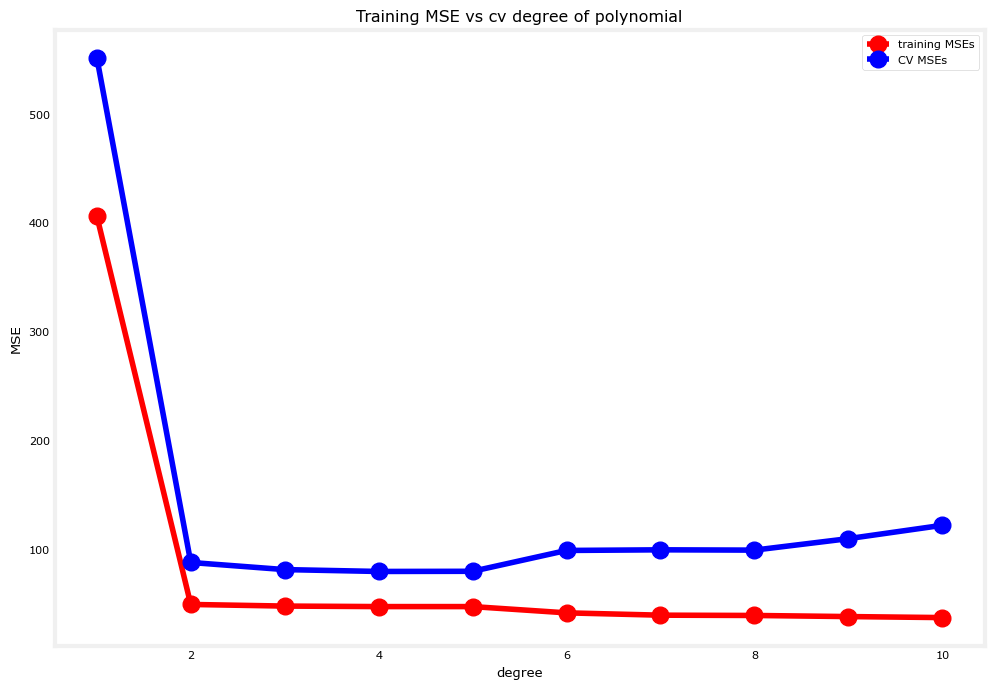

In [38]:
train_mses=[]
cv_mses=[]
models=[]
polys=[]
scalers=[]

for degree in range(1,11):
    
    # Add the polynomial feature to training set
    poly= PolynomialFeatures(degree,include_bias=False)
    x_train_mapped=poly.fit_transform(x_train)
    polys.append(poly)
    
    # scale the training set
    scaled_poly=StandardScaler()
    x_train_mapped_scaled=scaled_poly.fit_transform(x_train_mapped)
    scalers.append(scaled_poly)
    
    #create the model
    model=LinearRegression()
    model.fit(x_train_mapped_scaled,y_train)
    models.append(model)
    
    # compute the training error
    y_pred=model.predict(x_train_mapped_scaled)
    train_mse=mean_squared_error(y_train, y_pred)/2
    train_mses.append(train_mse)
    
    # add polynomial feature to cross validation set
    x_cv_mapped = poly.transform(x_cv)
    x_cv_mapped_scaled =scaled_poly.transform(x_cv_mapped)
    
    # calculating mse for cv
    y_pred=model.predict(x_cv_mapped_scaled)
    cv_mse=mean_squared_error(y_cv, y_pred)/2
    cv_mses.append(cv_mse)
    
# plot the graph using utils
degree=range(1,11)
utils.plot_train_cv_mses(degree, train_mses,cv_mses,title='Training MSE vs cv degree of polynomial')
    


In [39]:
#Choosing the best model

degree=np.argmin(cv_mses)+1
print(f' the lowest cv mse is found in the model of degree {degree}')

 the lowest cv mse is found in the model of degree 4


In [40]:
print(degree)
x_test_mapped=polys[degree-1].transform(x_test)
x_test_mapped_scaled=scalers[degree-1].transform(x_test_mapped)
y_pred=models[degree-1].predict(x_test_mapped_scaled)

test_mse=mean_squared_error(y_test, y_pred)/2

print(f"Training MSE: {train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

4
Training MSE: 47.15
Cross Validation MSE: 79.43
Test MSE: 104.63


In [41]:
#In summary, .fit_transform() is used for the initial fitting and transformation of the data, while .transform() is used for applying a previously learned transformation to new data.

## Nerual network

In [53]:
degree=1
poly=PolynomialFeatures(degree,include_bias=False)
x_train_mapped=poly.fit_transform(x_train)
x_cv_mapped=poly.transform(x_cv)
x_test_mapped=poly.transform(x_test)

# Using fit_transform for both x_train_mapped and x_cv_mapped would mean that the transformation for x_cv_mapped is learned independently from x_cv, which is not the typical or desired behavior for feature mapping.

In [54]:
scaler=StandardScaler()
x_train_mapped_scaled=scaler.fit_transform(x_train_mapped)
x_cv_mapped_scaled=scaler.transform(x_cv_mapped)
x_test_mapped_scaled=scaler.transform(x_test_mapped)

In [55]:
train_mses=[]
cv_mses=[]

nn_model=utils.build_models()

for model in nn_model:
    
    #setup loss and optimizer
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.1))
    
    print(f'training model{model.name}...')
    
    model.fit(x_train_mapped_scaled,y_train,epochs=300,verbose=0)
    
    print("done!")
    
    y_pred=model.predict(x_train_mapped_scaled)
    train_mse=mean_squared_error(y_train,y_pred)/2
    train_mses.append(train_mse)
    
    y_pred=model.predict(x_cv_mapped_scaled)
    cvmse=mean_squared_error(y_cv,y_pred)/2
    cv_mses.append(cvmse)
print("RESULTS:")
for model_num in range(len(train_mses)):
    print(
        f"Model {model_num+1}: Training MSE: {train_mses[model_num]:.2f}, " +
        f"CV MSE: {cv_mses[model_num]:.2f}"
        )

training modelmodel_1...
done!
1/1 [==============================] - 0s 16ms/step
training modelmodel_2...
done!
1/1 [==============================] - 0s 18ms/step
training modelmodel_3...
done!
1/1 [==============================] - 0s 21ms/step
RESULTS:
Model 1: Training MSE: 91.94, CV MSE: 141.24
Model 2: Training MSE: 73.40, CV MSE: 112.27
Model 3: Training MSE: 73.40, CV MSE: 112.30


In [56]:
model_num = 3

# Compute the test MSE
yhat = nn_model[model_num-1].predict(x_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Selected Model: {model_num}")
print(f"Training MSE: {train_mses[model_num-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[model_num-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

1/1 [==============================] - 0s 21ms/step
Selected Model: 3
Training MSE: 73.40
Cross Validation MSE: 112.30
Test MSE: 131.47
